# Run LSTM-autoencoder model

<p>
    Based on paper <a href="https://arxiv.org/abs/1607.00148v2">LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection</a>. The idea is to train sequence-to-sequence model on data without anomalies and use anomaly score derived from reconstruction error as anomaly metric.
<p>
    
<p> 
Sequence model and anomaly score is implemented in pip package and this notebook uses the pip package and provides some additional helper functions.
<p>


In [ ]:
# Install pip package
!cd ..; ./make_pip_package.sh; ./install_pip_package.sh

<h2>Helper functions and imports</h2>

In [2]:
import importlib

import matplotlib.pyplot as plt
import numpy as np

import lstm_autoencoder

importlib.reload(lstm_autoencoder)
plt.style.use('seaborn')


def anomaly_score(results):
    return [np.power(sample.input-sample.reconstruction, 2).mean() for sample in results]


def noise_level_vs_anomaly_score(timestamps, noise_levels, model, anomaly_score_fn):
    quantile_p50 = []
    results = []

    for noise_level in noise_levels:
        noise = lstm_autoencoder.GaussianNoise(noise_level)

        noise_level_timeseries = lstm_autoencoder.MultivariateTimeseries([
            lstm_autoencoder.Sin(phase=0, angular_frequency=2, amplitude=1) + noise,
            lstm_autoencoder.Sin(phase=0.1, angular_frequency=2.5, amplitude=1) + noise,
            lstm_autoencoder.Sin(phase=0.5, angular_frequency=3.5, amplitude=1) + noise,
        ])
        _, noise_level_data = noise_level_timeseries(timestamps)

        noise_level_data_results = model.predict(noise_level_data)

        results.append(anomaly_score_fn(noise_level_data_results))
        quantile_p50.append(np.quantile(np.array(results[-1]), 0.5))

    plt.figure()
    plt.plot(noise_levels, quantile_p50)
    plt.xlabel('Noise level')
    plt.ylabel('Anomaly score median')
    plt.title('Anomaly score versus noise level')


def plot_sample(sample, title=""):
    reconstruction_error = np.power(sample.input-sample.reconstruction, 2).mean()

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 5))    

    for ii in range(sample.input.shape[1]):
        ax[ii].plot(sample.input[:, ii])
        ax[ii].plot(sample.reconstruction[:, ii], '.')
        ax[ii].set_title("Timeseries {}".format(ii))

    plt.legend(("Input timeseries", "Reconstruction"))
    plt.suptitle(title + " Reconstruction error = " + str(reconstruction_error))


<h2> Training the autoencoder </h2>

In [7]:
# Time series parameters.
noise = lstm_autoencoder.GaussianNoise(0.01)

timeseries = lstm_autoencoder.MultivariateTimeseries([
    lstm_autoencoder.Sin(phase=0, angular_frequency=2, amplitude=1) + noise,
    lstm_autoencoder.Sin(phase=0.1, angular_frequency=2.5, amplitude=1) + noise,
    lstm_autoencoder.Sin(phase=0.5, angular_frequency=3.5, amplitude=1) + noise,
])

# Dataset parameters
training_size=3000
test_size=3000

training_timestamps = np.arange(0, training_size, 0.1)
_, training_data = timeseries(training_timestamps)

testing_timestamps = np.arange(training_size, training_size + test_size, 0.1)
_, testing_data = timeseries(testing_timestamps)


# Autoencoder model parameters
hidden_size = 3  # it is ok to have same hidden_size = number of timeseries due to temporal generation of reconstruction
num_layers = 5
window_size = 30
time_between_windows = 5
encoder_dropout = 0.01
decoder_dropout = 0.01

training_parameters = lstm_autoencoder.TrainingParameters(
    epochs=300,
    learning_rate=0.0005,
    minibatch_size=50,
    shuffle=False,
    teacher_forcing_ratio=0.5
)

# Creating the model
ae = lstm_autoencoder.Autoencoder(training_data.shape[1], hidden_size, num_layers, encoder_dropout, decoder_dropout, window_size, time_between_windows)

# Training model
ae.train(training_data,training_parameters)

# Training data inference
training_data_results = ae.predict(training_data)

# Testing data inference
testing_data_results = ae.predict(testing_data)

epoch: 0 loss 0.510341227054596
epoch: 50 loss 0.18491525948047638
epoch: 100 loss 0.14465723931789398
epoch: 150 loss 0.06967746466398239
epoch: 200 loss 0.0626206323504448
epoch: 250 loss 0.04243042692542076
epoch: 299 loss 0.02353040874004364


<h2>Reconstructions</h2>

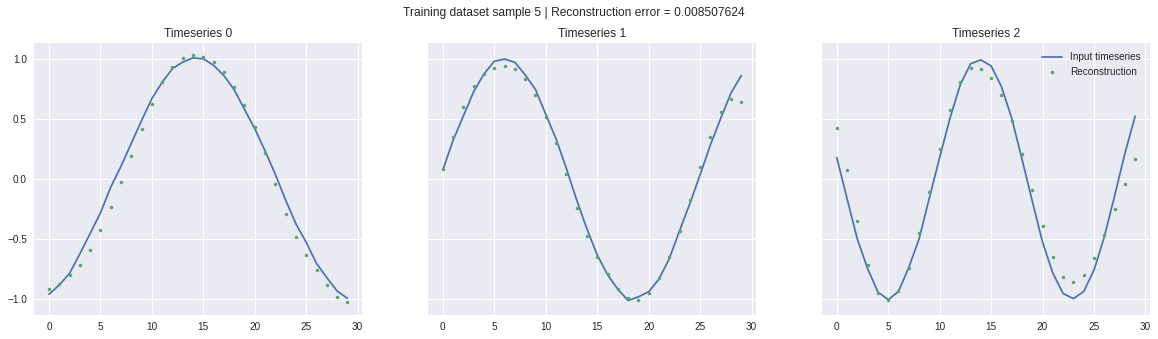

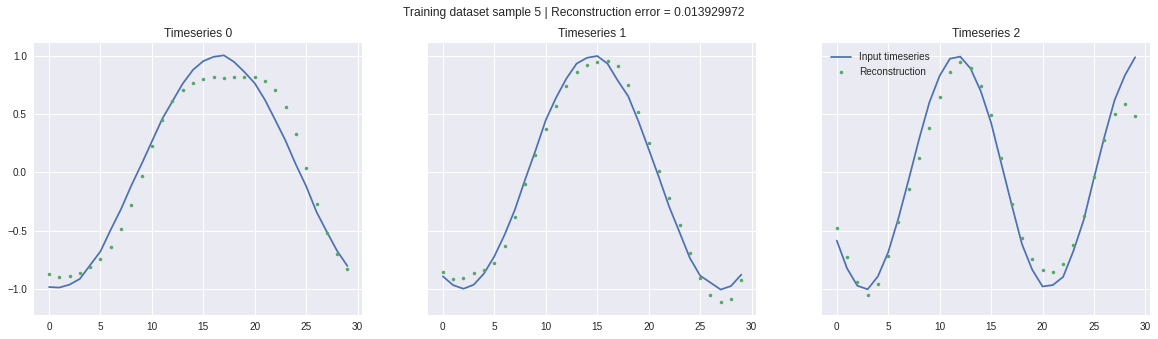

In [11]:
sample_idx = 5
plot_sample(training_data_results[sample_idx], "Training dataset sample {} |".format(sample_idx))
plot_sample(testing_data_results[sample_idx], "Training dataset sample {} |".format(sample_idx))

<h2>Training and test data anomaly scores</h2>
<p>
There is not big difference as both datasets have literally the same generation process.
<p>

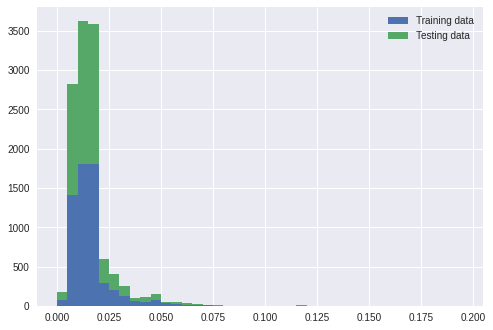

In [12]:
hist_data = np.array((anomaly_score(training_data_results), anomaly_score(testing_data_results))).transpose()
plt.hist(hist_data, stacked=True, bins=[ii*0.005 for ii in range(40)])
plt.legend(("Training data", "Testing data"))

<h2> Anomaly score versus noise level</h2>
<p>
Let us use increasing noise level as anomaly and see if the model is able to detect it. Based on the results it is clear that anomaly score is increasing as
noise level increases and therefore model works as intended.
<p>

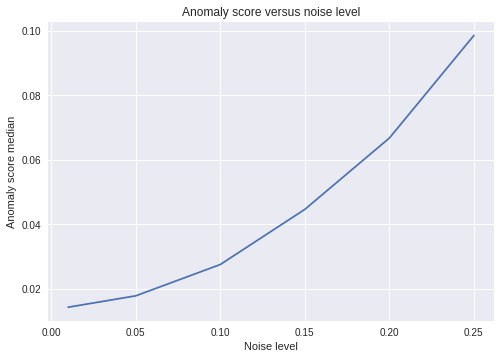

In [14]:
noise_level_vs_anomaly_score(testing_timestamps, [0.01, 0.05, 0.1, 0.15, 0.2, 0.25], ae, anomaly_score)